# RECURRENT NEURAL NETWORK for sentiment analysis on tweets regarding COVID using TensorFlow, NLTK, and GloVe for semantics.

_Data is from www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification_

__About Dataset:__<br>
Location: City, country, state, and/or country the tweet originated from.<br>
Tweet at: Date the tweet was published.<br>
Original Tweet: The tweet.<br>
Label: Sentiment that the tweet expresses.<br>
__Problem Statement:__<br>
Given data of COVID-19 related tweets and their corresponding sentiment, create a predictive model to then infer the sentiment of future COVID-19 related tweets.

In [1]:
import os
import time
import datetime
import requests
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords

from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

try:
    import unidecode
except ImportError:
    !pip install unidecode
    import unidecode

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lurap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. Evaluate the dataset.¶

In [2]:
train_df = pd.read_csv('covid-19-tweets/Corona_NLP_train.csv', encoding='latin1')
test_df = pd.read_csv('covid-19-tweets/Corona_NLP_test.csv', encoding='latin1')

print(f"Number of tweets for training: {train_df.shape[0]}")
print(f"Number of tweets for testing:  {test_df.shape[0]}")

Number of tweets for training: 41157
Number of tweets for testing:  3798


In [3]:
# Only the 'OriginalTweet' and 'Sentiment' columns are required
train_df = train_df[['OriginalTweet', 'Sentiment']]
test_df = test_df[['OriginalTweet', 'Sentiment']]

In [4]:
# Check what categories are used for 'Sentiment'
print(train_df['Sentiment'].value_counts())

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64


There are 5 categories for Sentiments:<br>
<--------------------------------------------------------------------><br>
Extremely$~~~~~~~~$Negative$~~~~~~~~$Neutral$~~~~~~~~$Positive$~~~~~~~~$Extremely<br>
Negative$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$Positive


Convert these sentiments to integers.

In [5]:
# Map sentiment labels to integers
sentiment_map = {
    'Extremely Positive': 4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative': 0
}
train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_map)
test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_map)

train_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,2
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,3
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",3
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",3
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",0


As seen from the preview of the data, tweets can be populated with lots of text noise.<br>
Here we use a function to cleanup each tweet so that it can be trimmed down to only its important words.<br>
We make use of a list of stop words from NLTK which removes unimportant words such as:<br>
“the”, “is”, “in”, “for”, “where”, “when”, “to”, “at”.

In [6]:
def cleanup(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet)  # remove links
    tweet = re.sub(r'www\S+', ' ', tweet)   # remove links
    tweet = re.sub(r'@\S+','', tweet)       # remove @/mentions
    tweet = re.sub(r'#\S+',' ', tweet)      # remove #/hashtags
    tweet = re.sub(r'%20', ' ', tweet)      # remove %20 
    tweet = re.sub(r'\d+',' ', tweet)       # remove digits
    tweet = unidecode.unidecode(tweet)      # convert accented characters to alphabet equivalent
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
    
    tweet = tweet.split()
    tweet = [word.lower() for word in tweet] # make every word lowercase to reduce unnecessary duplicates
    tweet = [word for word in tweet if word not in stop_words] # remove unnecessary words
    
    tweet = " ".join(tweet)
    return tweet

stop_words = stopwords.words('english')

In [7]:
# Clean them tweets
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(cleanup)
test_df['OriginalTweet']  = test_df['OriginalTweet'].apply(cleanup)

In [8]:
# This results in some tweets becoming empty strings
train_df = train_df[train_df['OriginalTweet'] != '']
test_df = test_df[test_df['OriginalTweet'] != '']

In [9]:
train_df.head()

,OriginalTweet,Sentiment
1,advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order,3
2,coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak,3
3,food stock one empty please dont panic enough food everyone take need stay calm stay safe,3
4,ready go supermarket outbreak im paranoid food stock litteraly empty serious thing please dont panic causes shortage,0
5,news regionas first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports,3


In [10]:
test_df.head()

,OriginalTweet,Sentiment
0,trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn soldout online grocers foodkick maxdelivery shoppers stock,0
1,couldnt find hand sanitizer fred meyer turned pack purellcheck concerns driving prices,3
2,find protect loved ones,4
3,buying hits city anxious shoppers stock foodampmedical supplies worker becomes st confirmed patient staged event,1
4,one week everyone buying baby milk powder next everyone buying toilet paper,2


We need to determine an appropriate vocabulary size to train the model on.<br>
Using all the words in the data could have a larger compute cost and may lead to overfitting.<br>
Count unique words and plot their frequency.<br>
This will help use determine vocabulary size for the model.

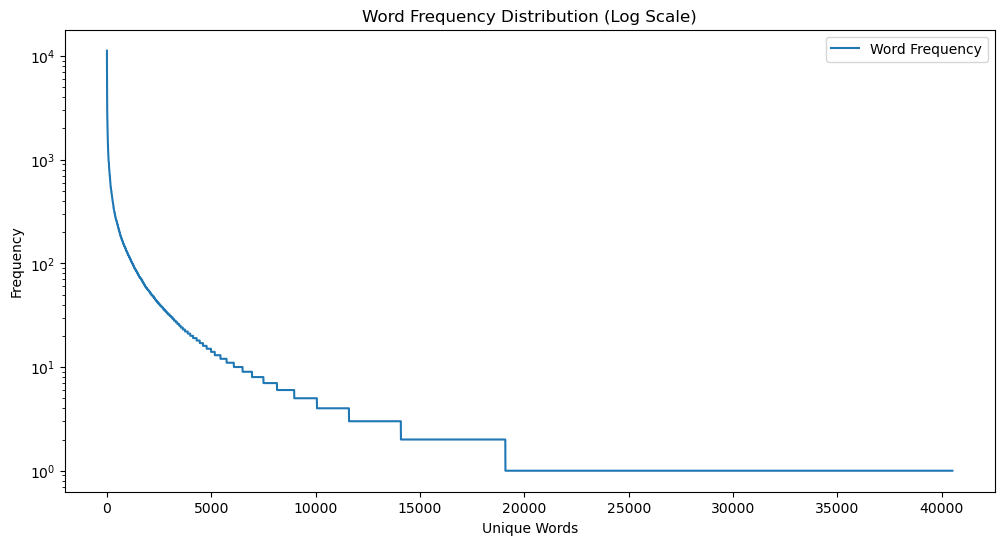

In [11]:
# All tweets:
combined_tweets = pd.concat([train_df['OriginalTweet'], test_df['OriginalTweet']])

# Count word frequencies
all_words = ' '.join(combined_tweets).split()
word_counts = Counter(all_words)

# Sort by frequency
sorted_word_counts = word_counts.most_common()
words, counts = zip(*sorted_word_counts)

# Plot word frequencies with a logarithmic scale
plt.figure(figsize=(12, 6))
plt.plot(range(len(counts)), counts, label='Word Frequency')
plt.yscale('log')
plt.xlabel('Unique Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution (Log Scale)')
plt.legend()
plt.show()

The graph shows a drastic drop in frequency before 20,000 unique words. Hence, we can limit our model's vocabulary size to the top 20,000 most frequent words.

We split our training data into training and validation with an 80-20 split.

In [12]:
# Split training data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['Sentiment'], random_state=42)

Another issue we might face is the class imbalance.<br>
Let's evaluate the frequency of each class.

In [13]:
# Count the representation of each class in our training data
print(train_data['Sentiment'].value_counts())

3    9136
1    7932
2    6132
4    5299
0    4385
Name: Sentiment, dtype: int64


From the frequency of the classes, we can create class weights to be applied on our model during training.<br>
This helps our model avoid having a bias towards the class with the greatest frequency.

In [14]:
# Frequencies of each class
class_frequencies = [9136, 7932, 6132, 5299, 4385]
classes = [3, 1, 2, 4, 0]

# Create a list of labels based on the class frequencies
labels = np.hstack([[cls] * freq for cls, freq in zip(classes, class_frequencies)])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=classes, y=labels)

# Convert to dictionary
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)

{3: 0.7198774080560421, 1: 0.8291477559253656, 2: 1.0725375081539466, 4: 1.2411398377052274, 0: 1.4998403648802736}


Now let's examine our final dataset.

In [15]:
print(f"Number of tweets left for training: {train_data.shape[0]}, from 41157")
print(f"Number of tweets left for testing:   {test_df.shape[0]}, from  3798")
print(f"Number of tweets for validating:     {val_data.shape[0]}")

Number of tweets left for training: 32884, from 41157
Number of tweets left for testing:   3795, from  3798
Number of tweets for validating:     8222


Use a tokenizer to transform our text data to numerical data.

In [16]:
# Initialize tokenizer
vocab_size = 20000
max_len = max(len(tweet.split()) for tweet in combined_tweets)
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_data['OriginalTweet'])

# Tokenize and pad sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['OriginalTweet']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['OriginalTweet']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['OriginalTweet']), maxlen=max_len)

y_train = train_data['Sentiment'].values
y_val = val_data['Sentiment'].values
y_test = test_df['Sentiment'].values

We use GloVe embeddings to enrich the model with a deeper understanding of language.<br>
This makes it more effective in capturing the sentiment and meaning behind the words in the tweets.

In [17]:
# URL for GloVe embeddings
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "covid-19-tweets/glove.6B.zip"
glove_extracted_path = "covid-19-tweets/glove.6B.100d.txt"

# Download the GloVe embeddings
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url, stream=True)
    with open(glove_zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=128):
            f.write(chunk)
    print("Download complete.")

# Unzip the GloVe embeddings
if not os.path.exists(glove_extracted_path):
    print("Unzipping GloVe embeddings...")
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Unzip complete.")
else:
    print("GloVe embeddings already downloaded and extracted.")

# Load GloVe embeddings
embedding_dim = 100
embeddings_index = {}
with open(glove_extracted_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_vector = np.array(values[1:], dtype='float32')
        embeddings_index[word] = embedding_vector

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

GloVe embeddings already downloaded and extracted.


Tweets with meaning contain words, and these words sequential.<br>
For our Model, we use a Recurrent Neural Network, which excels at handling sequential data.<br>
The layers in the model are:
1. Embedding Layer: receives the input words and captures the semantic meaning of the data.
2. Bidirectional LSTM Layer: captures long-term dependencies, and processes the data forwards and backwards.
3. Dense Layers: processes the features extracted by the LSTM and prepares them for the final classification.
4. Output Layer: classifies each tweet according to their inferred sentiment.

In [18]:
# Define the RNN model
model = Sequential([
    
    Embedding(input_dim=vocab_size,output_dim=embedding_dim,
              input_length=max_len,weights=[embedding_matrix],trainable=True
    ),
    
    Bidirectional(LSTM(128,return_sequences=False,dropout=0.2)
    ),
    
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=L2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=L2(0.01)),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping in case the model is not improving
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    restore_best_weights=True
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=2, 
    min_lr=0.00001
)

# Custom file name per training
date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Save the best model in case I want to continue training from there
checkpoint = ModelCheckpoint(
    f'covid-19-tweets/best_model_{date_time}.keras', 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

'\ncd "Documents\\DATA\\ACADEMICS\\Machine-Learning-Specialization-Coursera-1a6b6fc2851e6ab2d44f86b84db316a82a70e494\\my projects\\covid-19-tweets"\nrm -rf ./logs/\npython -m tensorboard.main --logdir="logs\x0cit"\nhttp://localhost:6006/\n'

In [19]:
# Start training timer
start_time = time.time()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Show training time 
end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Total Fitting Time: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3722 - loss: 2.9165
Epoch 1: val_accuracy improved from -inf to 0.58903, saving model to covid-19-tweets/best_model_20250124-123124.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 52s 180ms/step - accuracy: 0.3725 - loss: 2.9136 - val_accuracy: 0.5890 - val_loss: 1.3972 - learning_rate: 0.0010
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5766 - loss: 1.1133
Epoch 2: val_accuracy improved from 0.58903 to 0.66115, saving model to covid-19-tweets/best_model_20250124-123124.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 47s 183ms/step - accuracy: 0.5767 - loss: 1.1128 - val_accuracy: 0.6612 - val_loss: 0.8979 - learning_rate: 0.0010
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6989 - loss: 0.7793
Epoch 3: val_accuracy improved from 0.66115 to 0.71734, saving model to covid-19-tweets/best_model_20250124-123124.keras
257/257 ━━━━━━━━━━━━━━━━━━━━ 44s 170ms/step - accuracy: 0.6990 - loss: 0.7791 - val_accu

In [20]:
import glob

keras_files = glob.glob('covid-19-tweets/*.keras')
newest_file = max(keras_files, key=os.path.getmtime)
best_model = load_model(newest_file)
print(f"Loaded the newest model: {newest_file}")

Loaded the newest model: covid-19-tweets\best_model_20250124-123124.keras


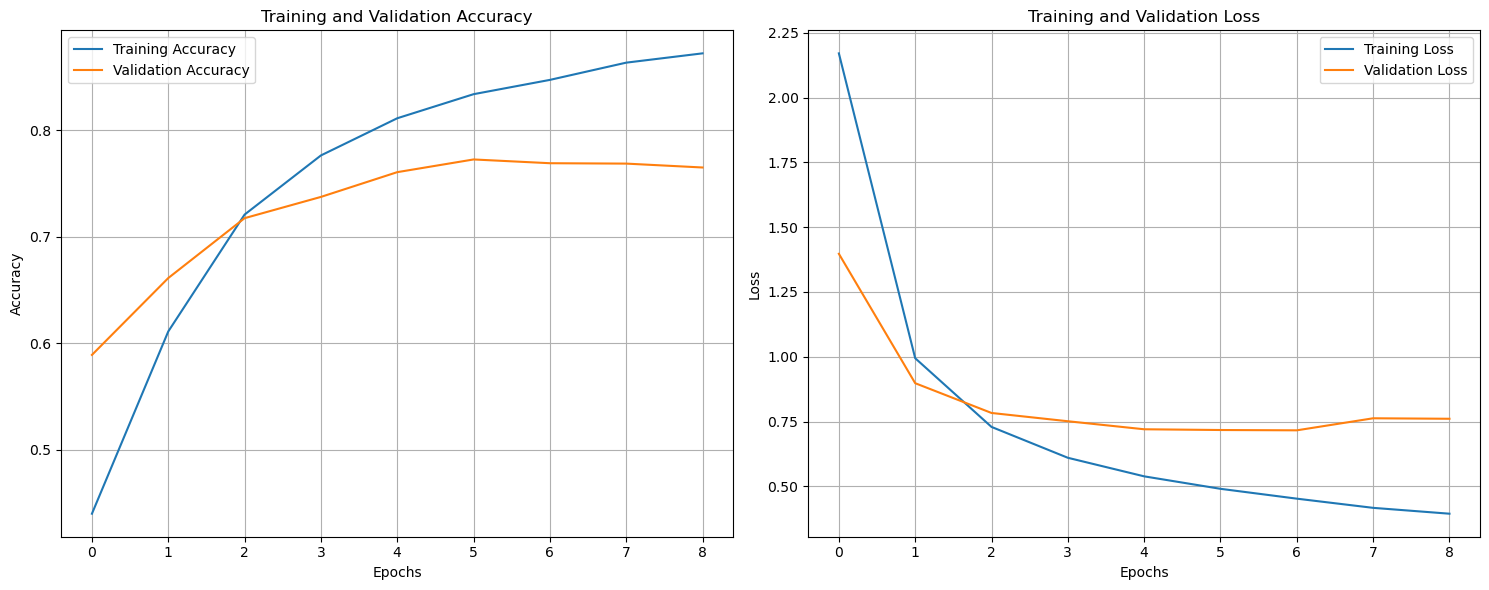

In [21]:
# Create a 1x2 grid of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot training & validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot training & validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


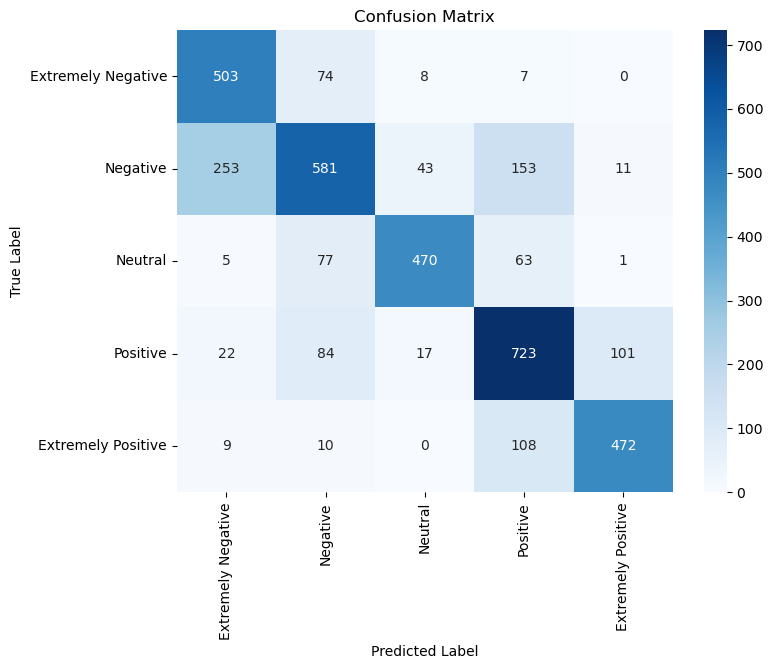

In [22]:
# Define the class labels (replace with your actual sentiment labels)
sentiment_str = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

# Get predictions for the test data using best_model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_str, yticklabels=sentiment_str)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=sentiment_str)

# Print the report
print("Classification Report:")
print(report)

Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.64      0.85      0.73       592
          Negative       0.70      0.56      0.62      1041
           Neutral       0.87      0.76      0.81       616
          Positive       0.69      0.76      0.72       947
Extremely Positive       0.81      0.79      0.80       599

          accuracy                           0.72      3795
         macro avg       0.74      0.74      0.74      3795
      weighted avg       0.73      0.72      0.72      3795



The model can classify sentiments of Extremely Negative, Negative, Neutral, Positive, and Extremely Positive with an F1 score of 72%.<br>
<br>
However, we can generalize the extremes of the sentiment and only classify sentiments according to Negative, Neutral, and Positive.

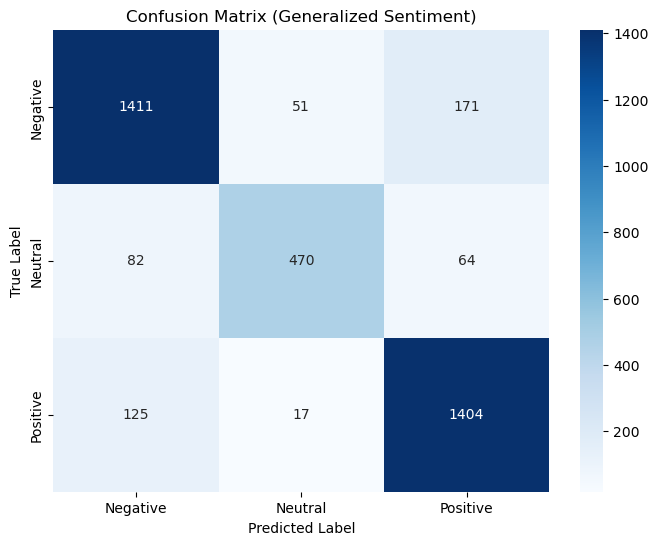

Classification Report (Generalized Sentiment):
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      1633
     Neutral       0.87      0.76      0.81       616
    Positive       0.86      0.91      0.88      1546

    accuracy                           0.87      3795
   macro avg       0.87      0.85      0.85      3795
weighted avg       0.87      0.87      0.86      3795



In [24]:
generalized_sentiment_str = ['Negative', 'Neutral', 'Positive']

# Convert the class labels
original_classes = [0, 1, 2, 3, 4]
generalized_classes = [0, 0, 1, 2, 2]
class_mapping = {original: generalized for original, generalized in zip(original_classes, generalized_classes)}

# Adjust y
y_test_generalized = np.array([class_mapping[label] for label in y_test])
y_pred_generalized = np.array([class_mapping[label] for label in y_pred_classes])

# Compute the confusion matrix
cm = confusion_matrix(y_test_generalized, y_pred_generalized)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generalized_sentiment_str, yticklabels=generalized_sentiment_str)
plt.title('Confusion Matrix (Generalized Sentiment)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate the classification report
report = classification_report(y_test_generalized, y_pred_generalized, target_names=generalized_sentiment_str)

# Print the report
print("Classification Report (Generalized Sentiment):")
print(report)

The model can classify sentiments of Negative, Neutral, and Positive with an F1 score of 87%.

In [25]:
# Get the original tweets from the test set
tweets = test_df['OriginalTweet'].values

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    'Tweet': tweets,
    'TrueLabel': y_test,
    'PredictedLabel': y_pred_classes
})

# Map numerical labels to sentiment strings for readability
sentiment_str = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
results_df['TrueSentiment'] = results_df['TrueLabel'].map(lambda x: sentiment_str[x])
results_df['PredictedSentiment'] = results_df['PredictedLabel'].map(lambda x: sentiment_str[x])

# Filter Positive tweets classified as Negative
positive_as_negative = results_df[
    (results_df['TrueSentiment'].isin(['Positive', 'Extremely Positive'])) & 
    (results_df['PredictedSentiment'].isin(['Negative', 'Extremely Negative']))
]

# Filter Negative tweets classified as Positive
negative_as_positive = results_df[
    (results_df['TrueSentiment'].isin(['Negative', 'Extremely Negative'])) & 
    (results_df['PredictedSentiment'].isin(['Positive', 'Extremely Positive']))
]

In [26]:
# Display Positive tweets classified as Negative
print("Positive Tweets Classified as Negative:")
for i, row in positive_as_negative.head(5).iterrows():
    print(f"Tweet: {row['Tweet']}")
    print(f"True Sentiment: {row['TrueSentiment']}")
    print(f"Predicted Sentiment: {row['PredictedSentiment']}")
    print("------")

# Display Negative tweets classified as Positive
print("Negative Tweets Classified as Positive:")
for i, row in negative_as_positive.head(5).iterrows():
    print(f"Tweet: {row['Tweet']}")
    print(f"True Sentiment: {row['TrueSentiment']}")
    print(f"Predicted Sentiment: {row['PredictedSentiment']}")
    print("------")

Positive Tweets Classified as Negative:
Tweet: business international markets webinar show navigate todayas exporting challenges rising commodity prices due covid virus
True Sentiment: Positive
Predicted Sentiment: Negative
------
Tweet: booked ticket event part package holiday offered alternative refund travel provider cancelled due check abtas consumer qampa
True Sentiment: Positive
Predicted Sentiment: Negative
------
Tweet: ok nothing panic italy imposing biggest restrictions civilian population since ww supermarkets able provide food workers told stay home bussiness
True Sentiment: Positive
Predicted Sentiment: Extremely Negative
------
Tweet: important update ceo brian beaulieu broadened scope covid webinar expect oil prices drop stock market developments retail sales unfolding situations china italy learn register
True Sentiment: Positive
Predicted Sentiment: Negative
------
Tweet: cpg retail major retailers china like starbucks uniqlo nike temporarily shuttered store sellers am